In [1]:
import sys
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy.spatial.distance import squareform, pdist
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import torch
import anndata as an
import scanpy as sc
import os
import gc
from importlib import reload

from datasets import Dataset, load_from_disk
from datasets import load_dataset
from geneformer import EmbExtractor
import geneformer

# classifer tools
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

# local imports
sys.path.insert(0, '../../scripts/')
import geneformer_utils as gtu

sns.set_style('white')
torch.cuda.empty_cache()

/home/cstansbu/miniconda3/envs/geneformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the model

In [2]:
"""Load the model"""
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/fine_tuned_models/geneformer-6L-30M_CellClassifier_cardiomyopathies_220224/"
# model_path = "/nfs/turbo/umms-indikar/shared/projects/geneformer/geneformer-12L-30M/"
model_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/"
model = gtu.load_model(model_path)
print('loaded!')

Some weights of BertForMaskedLM were not initialized from the model checkpoint at /scratch/indikar_root/indikar1/shared_data/geneformer/fine_tune/240715_geneformer_cellClassifier_no_induced/ksplit1/ and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


loaded!


In [3]:
# model

In [4]:
token_data_path = "/scratch/indikar_root/indikar1/shared_data/geneformer/resources/token_mapping.csv"
token_df = pd.read_csv(token_data_path)
token_df.head()

,gene_id,token_id,gene_name,nonzero_median,gene_version,gene_biotype,Chromosome,Start,End,scenic_tf
0,<pad>,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,<mask>,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,ENSG00000000003,2,TSPAN6,2.001186,15.0,protein_coding,X,100627107.0,100639991.0,False
3,ENSG00000000005,3,TNMD,3.228213,6.0,protein_coding,X,100584935.0,100599885.0,False
4,ENSG00000000419,4,DPM1,2.218874,14.0,protein_coding,20,50934866.0,50959140.0,False


# Load data

In [8]:
dpath = "/scratch/indikar_root/indikar1/shared_data/geneformer/datasets/"


def load_data(path, sample_size=None):
    """
    Loads data from a file, processes cell types, and returns a DataFrame.

    Args:
        path (str): The path to the dataset file.
        sample_size (int, optional): Number of cells to sample. Defaults to None.
    Returns:
        pandas.DataFrame: The processed DataFrame.
    """

    df = gtu.load_data_as_dataframe(path, num_cells=sample_size, shuffle=True)

    if "iHSC" in path:
        df['cell_type'] = "iHSC"
    elif "pellin" in path:
        df['cell_type'] = df['dataset']
    elif "weng" in path:
        df['cell_type'] = df['STD.CellType']
    else:
        df['cell_type'] = df['free_annotation']

    # Extract basename without extension and assign to 'dataset' column
    df['dataset'] = os.path.splitext(os.path.basename(path))[0]
    df = df[['input_ids', 'cell_type', 'dataset', 'length']]

    return df

sample_size = 1000

df = []

for dataset in os.listdir(dpath):
    data_path = f"{dpath}{dataset}"
    tmp = load_data(data_path, sample_size)
    
    df.append(tmp)
    
df = pd.concat(df)
print(f"{df.shape=}")
df = df[df['cell_type'].isin(['HSC', 'Fibroblasts'])]
print(f"{df.shape=}")

df['cell_type'].value_counts()

data = Dataset.from_pandas(df)
data

df.shape=(12000, 4)
df.shape=(1639, 4)


Dataset({
    features: ['input_ids', 'cell_type', 'dataset', 'length', '__index_level_0__'],
    num_rows: 1639
})

In [9]:
print(df['cell_type'].value_counts())

cell_type
HSC            1216
Fibroblasts     423
Name: count, dtype: int64


100%|██████████| 164/164 [00:45<00:00,  3.62it/s]
/home/oliven/miniconda3/envs/geneformer2/lib/python3.10/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [3, 33, 58, 308, 341]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


embs.shape=(1639, 512)


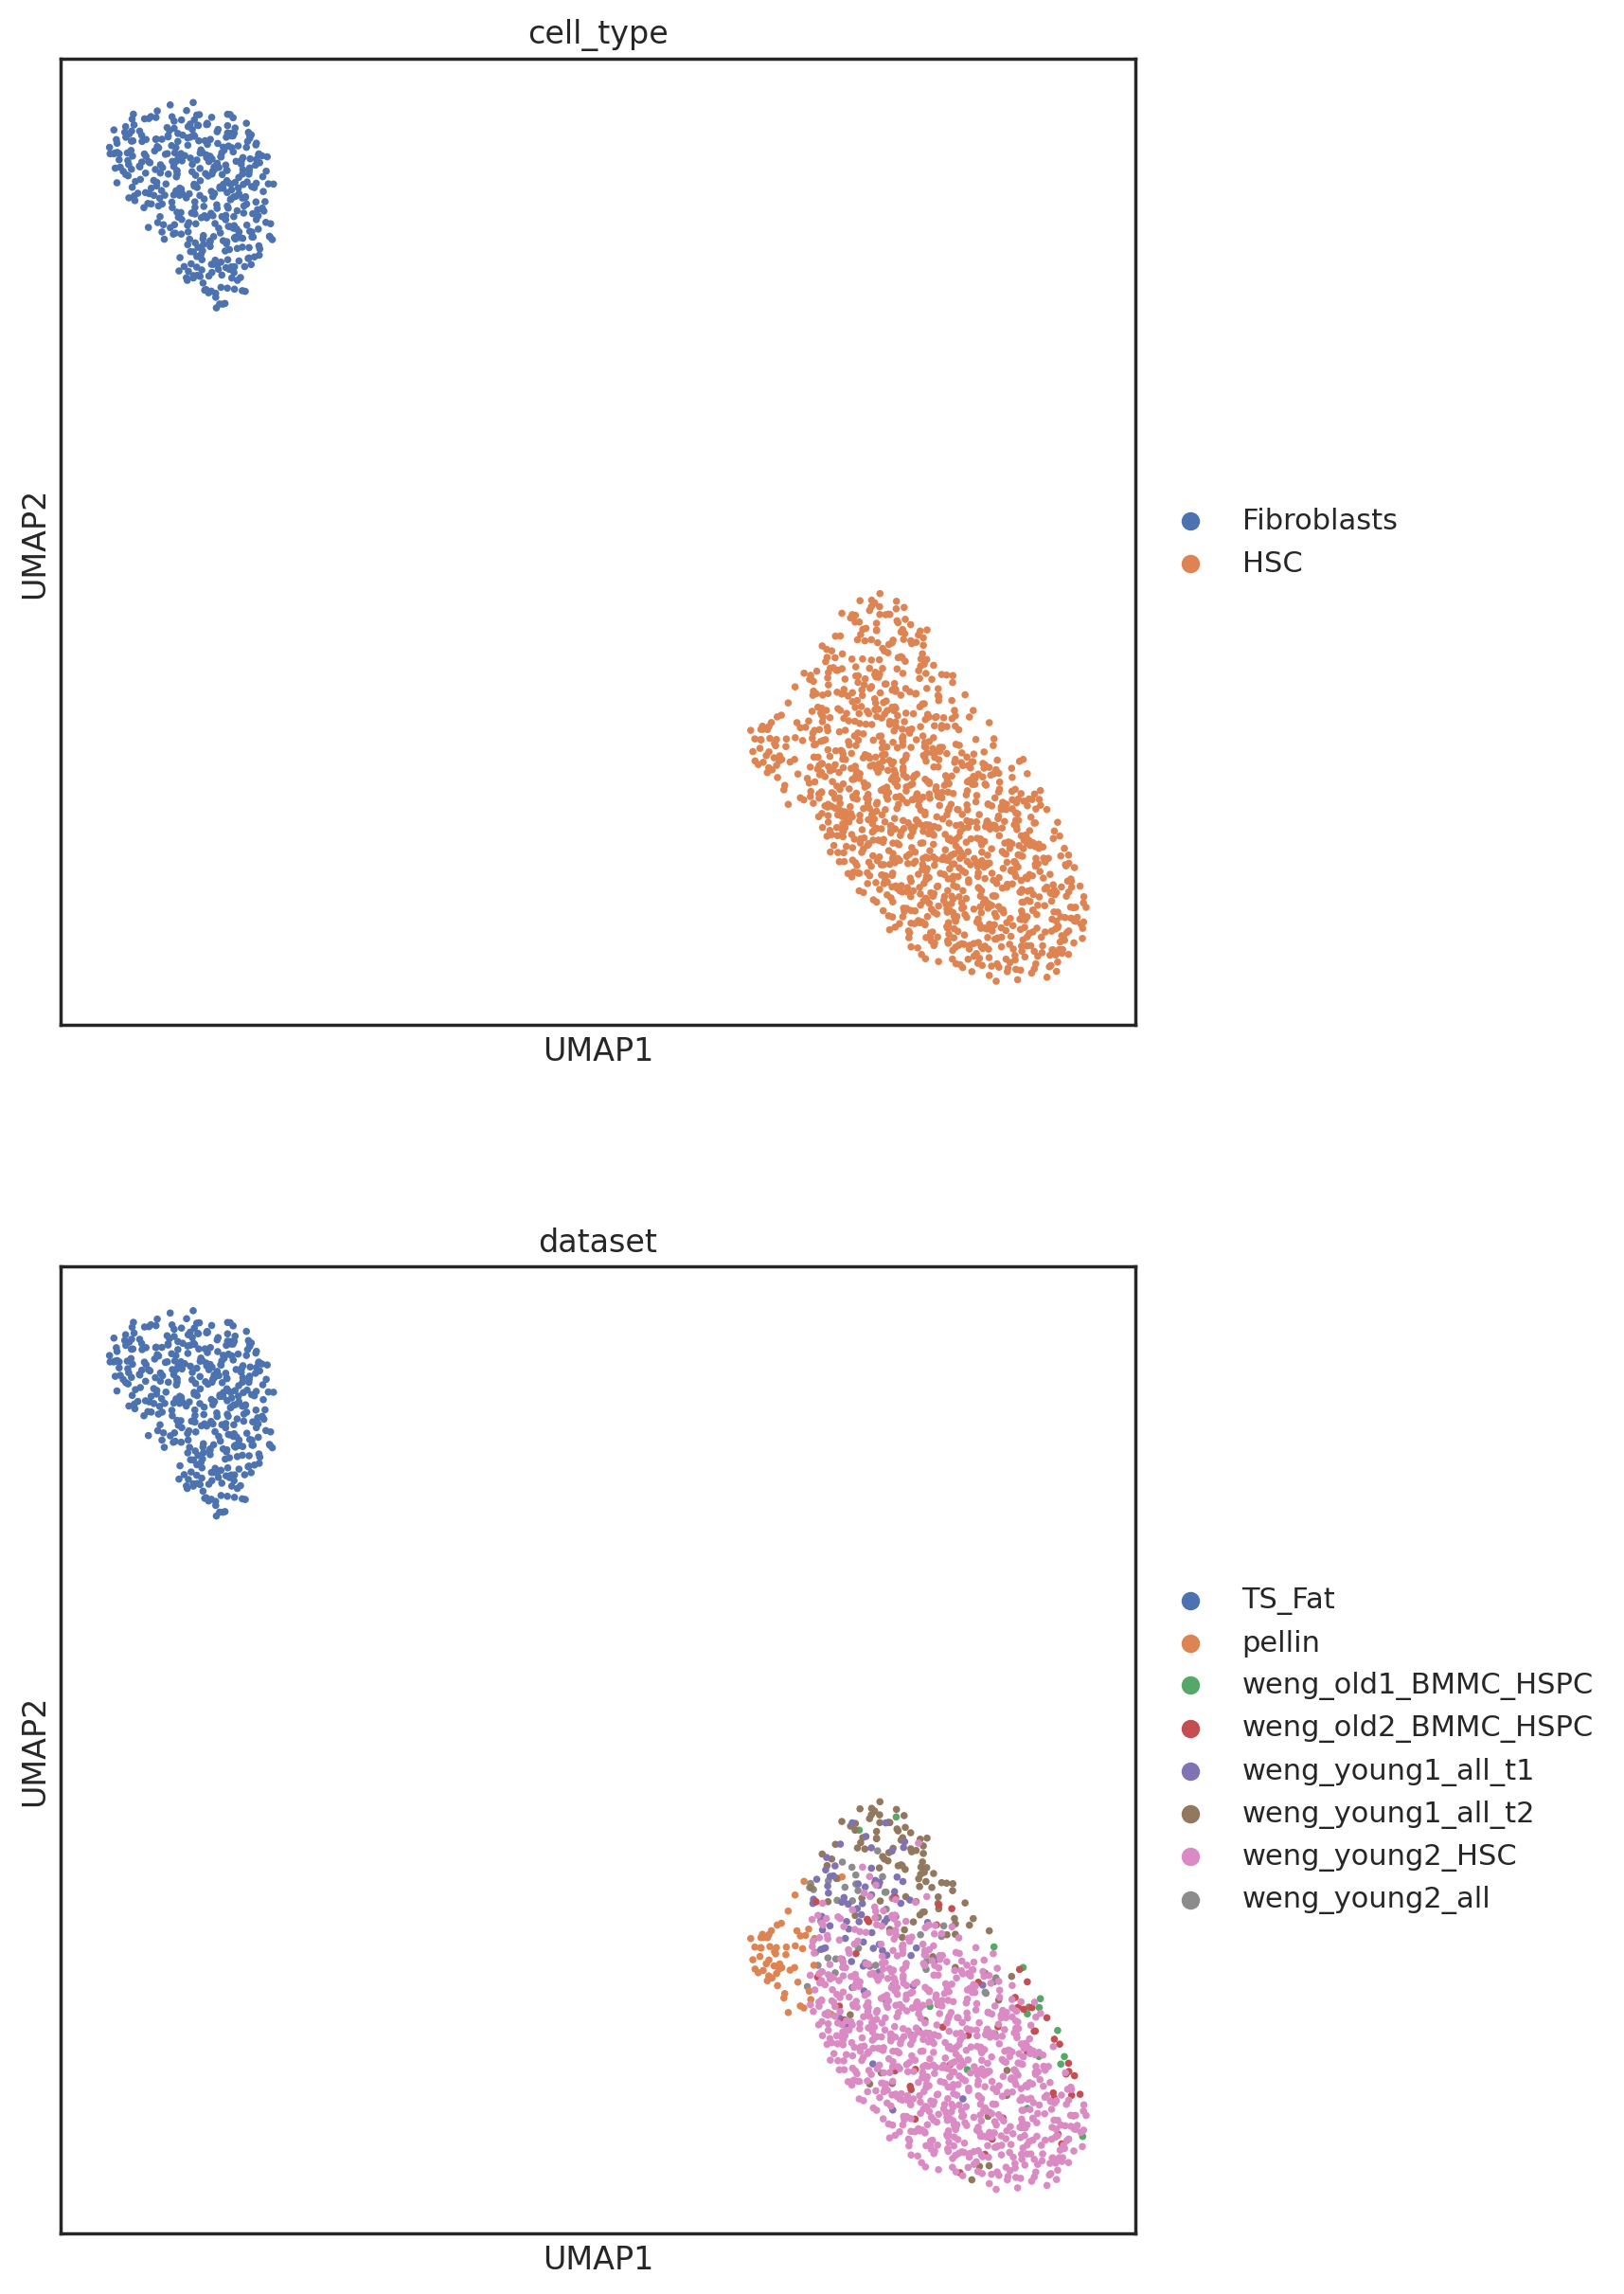

AnnData object with n_obs × n_vars = 1639 × 512
    obs: 'input_ids', 'cell_type', 'dataset', 'length'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors', 'dataset_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
reload(gtu)
torch.cuda.empty_cache()
embs = gtu.extract_embedding_in_mem(model, data, layer_to_quant=-1)
print(f"{embs.shape=}")

# translate into an anndata object and plot
adata = gtu.embedding_to_adata(embs)
adata.obs = df.copy()

sc.tl.pca(adata, n_comps=25)
sc.pp.neighbors(adata, n_neighbors=200)
sc.tl.umap(adata, 
           min_dist=0.75,
          )

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sc.pl.umap(
    adata,
    color=["cell_type", "dataset"],
    ncols=1,
    size=30,
)

adata

# Clean up cell types

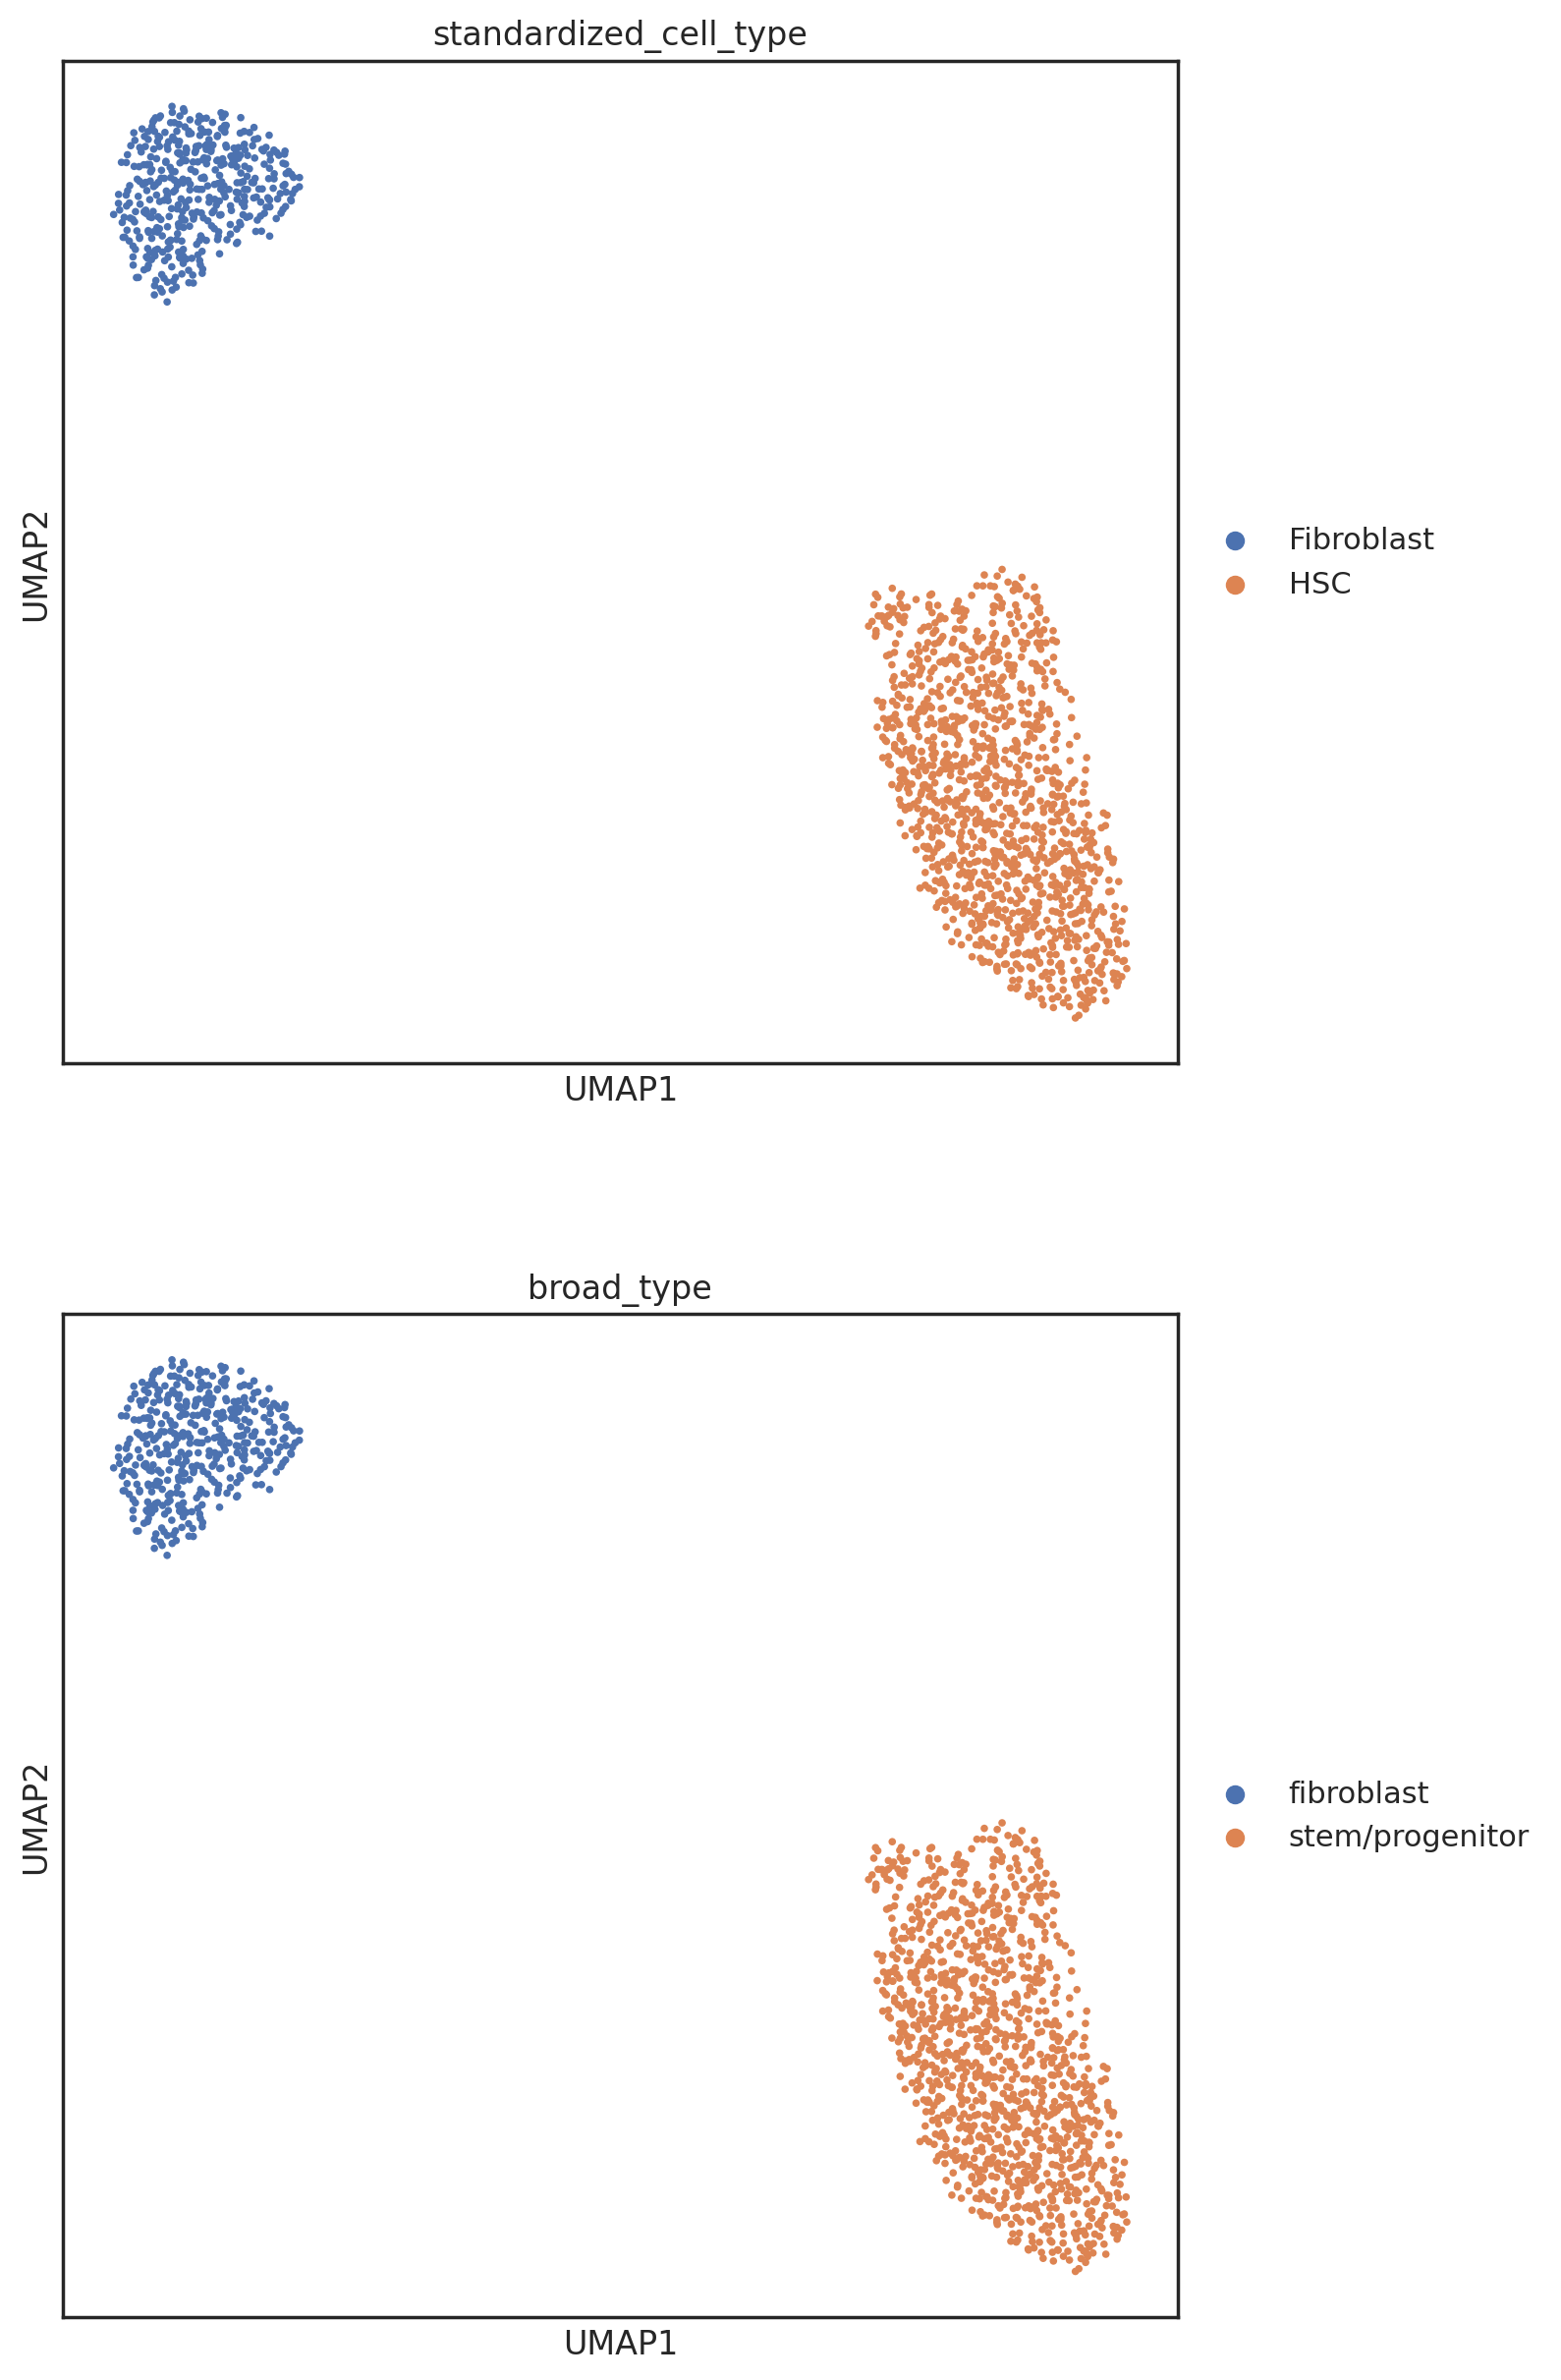

In [8]:
fpath = "ihsc_cell_types.csv"
cell_map = pd.read_csv(fpath, comment="#")

adata.obs = pd.merge(adata.obs, 
                     cell_map,
                     how='left',
                     left_on='cell_type',
                     right_on='label',
                    )

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7
sc.pl.umap(
    adata,
    color=["standardized_cell_type","broad_type"],
    ncols=1,
    size=30,
)

In [9]:
df[df['dataset'] == "pellin"]['cell_type'].value_counts()

cell_type
HSC    58
Name: count, dtype: int64

# COMPUTE HSC CENTROID

In [10]:
HSC_embeddings = adata[adata.obs['cell_type'] == 'HSC', :].X
hsc_cenroid = HSC_embeddings.mean(axis=0)
hsc_cenroid = hsc_cenroid.reshape(1, -1)
print(f"{hsc_cenroid.shape=}")

hsc_cenroid.shape=(1, 512)


In [11]:
tfs = [
    'FOSB',
    'FOS',
    'REL',
    'STAT5A',
    'GATA2',
]

tf_tokens = token_df[token_df['gene_name'].isin(tfs)]['token_id'].to_list()
print(tf_tokens)

[5675, 5806, 10804, 12698, 14409]


# Perturb the Data

In [13]:
def perturb_data(df, tokens):
    """
    Perturbs the input_ids in a DataFrame by prepending a list of tokens.

    Args:
      df (pandas.DataFrame): The input DataFrame with an 'input_ids' column.
      tokens (list): The list of tokens to prepend.

    Returns:
      pandas.DataFrame: The combined DataFrame with original and perturbed data.
    """

    perturbed = df.copy()
    perturbed['state'] = 'perturbed'
    perturbed['input_ids'] = perturbed['input_ids'].apply(
      lambda x: list(tokens) + list(x)[:len(x) - len(tokens)]
    )

    df['state'] = 'raw'
    combined_df = pd.concat([df, perturbed])
    return combined_df

sample_size = 400
fb_cells = adata.obs[adata.obs['cell_type'] == 'Fibroblasts'].copy()
fb_cells = fb_cells.sample(sample_size)
fb_cells = fb_cells.reset_index(names='cell_id')

perturbed = perturb_data(fb_cells, tf_tokens)
perturbed = perturbed.reset_index(drop=True)
perturbed_data = Dataset.from_pandas(perturbed)

# extract the embeddings
torch.cuda.empty_cache()
test_embs = gtu.extract_embedding_in_mem(model, perturbed_data, layer_to_quant=-1)

perturbed

100%|██████████| 80/80 [00:30<00:00,  2.61it/s]


,cell_id,input_ids,cell_type,dataset,length,label,standardized_cell_type,broad_type,state
0,457,"[5941, 4232, 5675, 17626, 8784, 416, 287, 1860...",Fibroblasts,TS_Fat,1389,Fibroblasts,Fibroblast,fibroblast,raw
1,650,"[9009, 16916, 3878, 22668, 454, 7122, 18367, 2...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw
2,670,"[16916, 9009, 11293, 16876, 18367, 12908, 5675...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw
3,630,"[16916, 22668, 2124, 220, 1732, 376, 7111, 259...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw
4,672,"[16916, 3878, 2592, 9009, 3784, 9123, 19437, 2...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw
...,...,...,...,...,...,...,...,...,...
795,736,"[5675, 5806, 10804, 12698, 14409, 11900, 10973...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,perturbed
796,446,"[5675, 5806, 10804, 12698, 14409, 1732, 10769,...",Fibroblasts,TS_Fat,1926,Fibroblasts,Fibroblast,fibroblast,perturbed
797,673,"[5675, 5806, 10804, 12698, 14409, 16916, 3878,...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,perturbed
798,611,"[5675, 5806, 10804, 12698, 14409, 16876, 16916...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,perturbed


# Compute Distance to HSC

In [14]:
metric = 'cosine'
Xa = test_embs.to_numpy()
Xb = hsc_cenroid

print(f"{Xa.shape=} {Xb.shape=}")
D = cdist(Xa, Xb, metric=metric)
print(f"{D.shape=}")

perturbed['distance_to_hsc'] = D.ravel()
perturbed

Xa.shape=(800, 512) Xb.shape=(1, 512)
D.shape=(800, 1)


,cell_id,input_ids,cell_type,dataset,length,label,standardized_cell_type,broad_type,state,distance_to_hsc
0,457,"[5941, 4232, 5675, 17626, 8784, 416, 287, 1860...",Fibroblasts,TS_Fat,1389,Fibroblasts,Fibroblast,fibroblast,raw,0.800092
1,650,"[9009, 16916, 3878, 22668, 454, 7122, 18367, 2...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw,0.849969
2,670,"[16916, 9009, 11293, 16876, 18367, 12908, 5675...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw,0.857654
3,630,"[16916, 22668, 2124, 220, 1732, 376, 7111, 259...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw,0.922601
4,672,"[16916, 3878, 2592, 9009, 3784, 9123, 19437, 2...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,raw,0.768549
...,...,...,...,...,...,...,...,...,...,...
795,736,"[5675, 5806, 10804, 12698, 14409, 11900, 10973...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,perturbed,0.878054
796,446,"[5675, 5806, 10804, 12698, 14409, 1732, 10769,...",Fibroblasts,TS_Fat,1926,Fibroblasts,Fibroblast,fibroblast,perturbed,0.899302
797,673,"[5675, 5806, 10804, 12698, 14409, 16916, 3878,...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,perturbed,0.806062
798,611,"[5675, 5806, 10804, 12698, 14409, 16876, 16916...",Fibroblasts,TS_Fat,2048,Fibroblasts,Fibroblast,fibroblast,perturbed,0.914530


# Compute distance between raw and perturbed states

In [15]:
P = squareform(pdist(Xa, metric=metric))
print(f"{P.shape=}")
print(P)

P.shape=(800, 800)
[[0.         0.19733693 0.20512162 ... 0.19009716 0.17676455 0.19373087]
 [0.19733693 0.         0.01497144 ... 0.02292629 0.04390875 0.03945848]
 [0.20512162 0.01497144 0.         ... 0.01465868 0.04423023 0.02718171]
 ...
 [0.19009716 0.02292629 0.01465868 ... 0.         0.04191995 0.03397669]
 [0.17676455 0.04390875 0.04423023 ... 0.04191995 0.         0.01930957]
 [0.19373087 0.03945848 0.02718171 ... 0.03397669 0.01930957 0.        ]]


In [16]:
result = []

for cell_id, group in perturbed.groupby('cell_id'):
    idx = group.index.to_list()
    
    raw_row = group.iloc[0]
    perturbed_row = group.iloc[1]

    row = {
        'cell_id' : cell_id,
        'raw_to_hsc' : raw_row['distance_to_hsc'],
        'perturbed_to_hsc' : perturbed_row['distance_to_hsc'],
        'raw_to_perturbed' : P[idx[0], idx[1]],
    }
    
    result.append(row)
    
result = pd.DataFrame(result)
result.head()

,cell_id,raw_to_hsc,perturbed_to_hsc,raw_to_perturbed
0,354,0.938057,0.920485,0.010464
1,355,0.893294,0.909667,0.004498
2,356,0.847703,0.861059,0.015072
3,357,0.917341,0.899227,0.006859
4,358,0.858618,0.874189,0.007126


<Axes: xlabel='raw_to_hsc', ylabel='Count'>

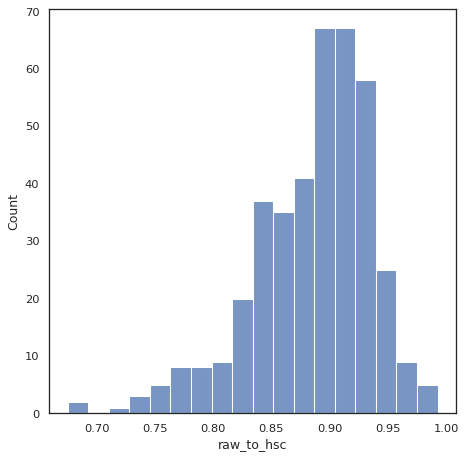

In [17]:
plt.rcParams['figure.dpi'] = 75
sns.histplot(data=result, 
             x='raw_to_hsc')

<Axes: xlabel='perturbed_to_hsc', ylabel='Count'>

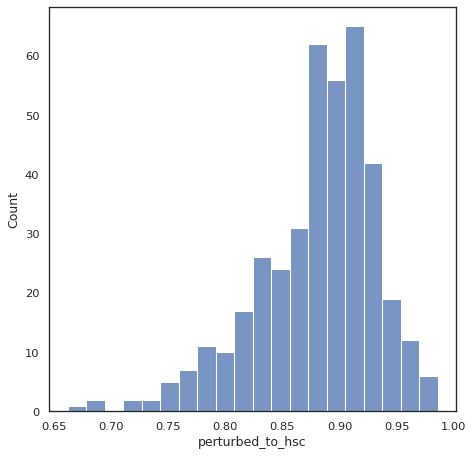

In [18]:
plt.rcParams['figure.dpi'] = 75
sns.histplot(data=result, 
             x='perturbed_to_hsc')

<Axes: xlabel='raw_to_perturbed', ylabel='Count'>

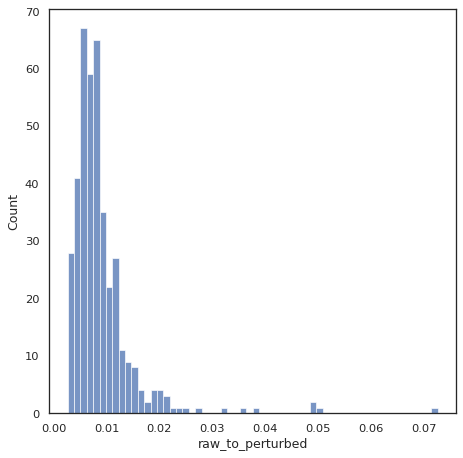

In [19]:
plt.rcParams['figure.dpi'] = 75
sns.histplot(data=result, 
             x='raw_to_perturbed')

In [ ]:
break